In [13]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from keras import models, optimizers, backend
# from keras.layers import core, convolutional, pooling
from sklearn import model_selection
import cv2
import random

from tensorflow.keras.utils import Sequence
import matplotlib.image as mpimg

import json
import matplotlib.pyplot as plt

from PIL import Image
import skimage 
from skimage.transform import resize

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelEncoder


from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from lime import lime_image

from keras.applications import inception_v3 as inc_net
from keras.applications.imagenet_utils import decode_predictions




In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, Model


In [20]:
import tensorflow_addons as tfa

In [31]:
from datetime import datetime


In [2]:
dataset = ('C:/Users/Ketan/Thesis/self-driving-car/challenges/challenge-2')

In [3]:
# Read the data
df = pd.io.parsers.read_csv(os.path.join(dataset, 'out.csv'))
# # Split data into training and validation sets
df_train, df_valid = model_selection.train_test_split(df, test_size=.2)

In [4]:
pd.options.mode.chained_assignment = None #default = warn

In [5]:
df_train['angle_range'] = pd.qcut(df_train['angle'], q=10)
df_valid['angle_range'] = pd.qcut(df_valid['angle'], q=10)

In [6]:
df_train['labels']= df_train['angle_range'].cat.codes
df_valid['labels']= df_valid['angle_range'].cat.codes

In [7]:
df_train['labels'] = df_train['labels'].apply(str)
df_valid['labels'] = df_valid['labels'].apply(str)


In [9]:
datagen=ImageDataGenerator(rescale=1./255, rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        shear_range=0.1,
        zoom_range=[0.75, 1],
        horizontal_flip=True,
        validation_split=0.2)
train_generator=datagen.flow_from_dataframe(dataframe=df_train, directory=dataset, x_col="File", y_col="labels", 
                                            class_mode="categorical", target_size=(480,640), batch_size=32)

Found 4491 validated image filenames belonging to 10 classes.


In [10]:
valid_generator=datagen.flow_from_dataframe(dataframe=df_valid, directory=dataset, 
                                            x_col="File", y_col="labels", class_mode="categorical", target_size=(480,640), 
                                            batch_size=32)

Found 1123 validated image filenames belonging to 10 classes.


In [15]:
inputs = layers.Input(shape=(480, 640, 3))
base_model = ResNet50(include_top=False, input_tensor=inputs, weights="imagenet")


In [16]:
base_model.trainable = False


In [47]:
x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = layers.BatchNormalization()(x)
top_dropout_rate = 0.4
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(10, activation='softmax', name="pred")(x)

# Compile
model = Model(inputs, outputs, name="ResNet50")

In [ ]:
# model = models.Sequential()
# # model.add(InputLayer(input_shape=(128,380, 3)))
# model.add(base_model)
# model.add(layers.GlobalAveragePooling2D())
# # model.add(core.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(.5))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(.5))
# # model.add(core.Dense(10, activation='relu'))
# model.add(layers.Dense(10, activation='softmax'))

In [22]:
radam = tfa.optimizers.RectifiedAdam(learning_rate=1e-04)
optimizer   = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)


In [48]:
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['AUC', 'categorical_accuracy'])

In [49]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 15, 20, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [26]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [27]:
model_name = 'tl_classification_udacity'

In [29]:
callback1 = tf.keras.callbacks.EarlyStopping(monitor="categorical_crossentropy",
        min_delta=1,  # model should improve by at least 1%
        patience=1,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=2,
        mode="min",
        restore_best_weights=True) # restore the best model with the lowest validation error)

In [33]:
logdir = (
        "logs_tl_cs_ud/scalars/" + model_name + "_" + datetime.now().strftime("%Y%m%d-%H%M%S")
    )  # create a folder for each model.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [35]:
callback2 = tf.keras.callbacks.ModelCheckpoint( "./models_tl_cs_ud/" + model_name + ".h5",
        monitor="categorical_crossentropy",
        verbose=0,
        save_best_only=True,  # save the best model
        mode="min",
        save_freq="epoch") # save every epoch
    

In [ ]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5, callbacks=[callback1, tensorboard_callback, callback2])

In [54]:
import keras.backend as K

In [67]:
base_model1 = ResNet50(include_top=False, input_tensor=inputs, weights="imagenet", pooling = 'max')

In [68]:
base_model1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 486, 646, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 240, 320, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 240, 320, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [69]:
f = K.function(base_model1.input, base_model1.output)


In [70]:
datagen1=ImageDataGenerator(rescale=1./255)

In [71]:
train_generator1=datagen1.flow_from_dataframe(dataframe=df_train, directory=dataset, x_col="File", y_col="labels", 
                                            class_mode="categorical", target_size=(480,640), batch_size=1)

Found 4491 validated image filenames belonging to 10 classes.


In [82]:
# next(train_generator1)

In [73]:
def get_features(train_generator1,n ):
    
    feat = []
    y_val = []
    
    for i in range (n):
        X,y = next(train_generator1)
        out = f(X)
        feat.append(out[0])
        y_val.append(y[0])
    return y_val, feat
        


In [181]:
X,y = next(train_generator1)


In [182]:
y_val2 = []
y_val.append(y[0])


In [115]:
out.shape

(1, 2048)

In [74]:
y_val,feat = get_features(train_generator1, len(df_train))

In [75]:
from sklearn.decomposition import PCA

In [76]:
pca = PCA(n_components=2)
pca.fit(feat)
feats = pca.transform(feat)

In [81]:
feats.shape

(4491, 2)

In [189]:
len(y_val)

4491

In [167]:
abc = np.nonzero(y_val)[0]

In [190]:
abc

array([   0,    1,    2, ..., 4488, 4489, 4490], dtype=int64)

In [84]:
import plotly.express as px


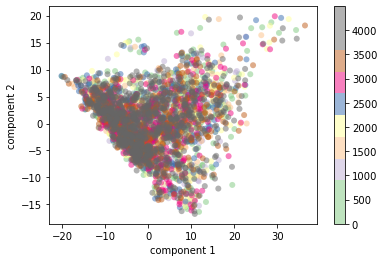

In [186]:
plt.scatter(feats[:, 0], feats[:, 1],
            c=abc, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();